<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/examples/test_fec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

fatal: destination path 'OptiCommPy' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Processing /content/OptiCommPy
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for OpticCommpy: filename=OpticCommpy-0.1.0-py3-none-any.whl size=40287 sha256=49aa4e74e3f6a51980a21fb2b46a2b7b5f4b57e2e581417cb54753dc30efba1d
  Stored in directory: /tmp/pip-ephem-wheel-cache-oobd55cb/wheels/86/a6/e4/b590dcf328df4752195276814fd608a284f1ead675da00b64c
Successfully built OpticCommpy
  Attempting uninstall: OpticCommpy
    Found existing installation: Optic

In [2]:
from optic.modulation import modulateGray, demodulateGray, GrayMapping
from optic.metrics import signal_power, calcLLR, fastBERcalc
from optic.fec import ldpcEncode, ldpcDecode
from optic.models import awgn
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from scipy import io
from tqdm.notebook import tqdm
from numba import njit

import os.path as path

In [3]:
from commpy.channelcoding import ldpc
from commpy.channelcoding.ldpc import triang_ldpc_systematic_encode as encodeLDPC
from commpy.channelcoding.ldpc import ldpc_bp_decode as decodeLDPC
from commpy.channelcoding.interleavers import RandInterlv

In [4]:
%load_ext autoreload
%autoreload 2

## Create LDPCparam files

In [5]:
# pathdir = r'C:\Users\edson.DESKTOP-54IJM4F\Desktop\DVBS2'

# d = sp.io.loadmat(pathdir+'\LDPC_ARJA_1280b_R45.mat')
# H = d['H']

# # H = d['LDPC']['H'] # parity check matrix
# # H = H[0][0][0][0][0]
# H = sp.sparse.csr_matrix.todense(H).astype(np.int8)
# H = np.asarray(H)

# file_path = r'C:\Users\edson.DESKTOP-54IJM4F\Documents\GitHub\OptiCommPy-private\optic\fecParams\LDPC_ARJA_1280b_R45.txt'

# ldpc.write_ldpc_params(H, file_path)

In [6]:
# select FEC parameters
family = "DVBS2"
R = 56
n = 64800

if 'google.colab' in str(get_ipython()):
  mainDir  = path.abspath(path.join("../"))
  filename = '/LDPC_' + family + '_' + str(n) + 'b_R' + str(R) + '.txt'
  filePath = mainDir + r'/OptiCommPy/optic/fecParams/' + filename
else:
  mainDir  = path.abspath(path.join("../"))
  filename = '\LDPC_' + family + '_' + str(n) + 'b_R' + str(R) + '.txt'
  filePath = mainDir + r'\optic\fecParams' + filename

filePath

'/content/OptiCommPy/optic/fecParams//LDPC_DVBS2_64800b_R56.txt'

In [7]:
# Run AWGN simulation 
EbN0dB = 10
M      = 64
Nwords = 20
nIter  = 10

# FEC parameters
LDPCparams = ldpc.get_ldpc_code_params(filePath)
K = LDPCparams['n_vnodes'] - LDPCparams['n_cnodes']

LDPCparams['filename'] = filename

# modulation parameters
constSymb = GrayMapping(M,'qam')        # constellation
bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
bitMap = bitMap.reshape(-1, int(np.log2(M)))
Es = signal_power(constSymb)                 # mean symbol energy

# generate random bits
bits = np.random.randint(2, size = (K, Nwords))

# encode data bits with LDPC soft-FEC
bitsTx, codedBitsTx, interlv = ldpcEncode(bits, LDPCparams)

# Map bits to constellation symbols
symbTx = modulateGray(bitsTx, M, 'qam')

# Normalize symbols energy to 1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# AWGN    
snrdB  = EbN0dB + 10*np.log10(np.log2(M))
symbRx = awgn(symbTx, snrdB)

# pre-FEC BER calculation (hard demodulation)
BER, _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
print('BER = %.2e'%BER[0])

# soft-demodulation
noiseVar = 1/10**(snrdB/10)
llr = calcLLR(symbRx, noiseVar, constSymb/np.sqrt(Es), bitMap)

# soft-FEC decoding
decodedBits, llr_out = ldpcDecode(llr, interlv, LDPCparams, nIter, alg="SPA")

# post-FEC BER calculation
BERpost = np.mean(np.logical_xor(bits, decodedBits[0:K,:]))

print('BERpostFEC = %.2e'%BERpost)
print('Number of bits = ', decodedBits.size)

BER = 2.68e-02
BERpostFEC = 0.00e+00
Number of bits =  1296000


In [8]:
Nwords = 20
nIter  = 50

# FEC parameters
LDPCparams = ldpc.get_ldpc_code_params(filePath)
LDPCparams['filename'] = filename
K = LDPCparams['n_vnodes'] - LDPCparams['n_cnodes']

# Run BER vs Ebn0 Monte Carlo simulation 
qamOrder  = [64]  # Modulation order
EbN0dB_  = np.arange(7, 9.5, 0.05)

BERpre   = np.zeros((len(EbN0dB_),len(qamOrder)))
BERpost  = np.zeros((len(EbN0dB_),len(qamOrder)))

BERpre[:]  = np.nan
BERpost[:] = np.nan

for ii, M in enumerate(qamOrder):
    print('run sim: M = ', M)

    # modulation parameters
    constSymb = GrayMapping(M,'qam')        # constellation
    bitMap = demodulateGray(constSymb, M, 'qam') # bit mapping
    bitMap = bitMap.reshape(-1, int(np.log2(M)))
    Es = signal_power(constSymb) # mean symbol energy

    for indSNR in tqdm(range(EbN0dB_.size)):

        EbN0dB = EbN0dB_[indSNR]

        # generate random bits
        bits = np.random.randint(2, size = (K, Nwords))

        # encode data bits with LDPC soft-FEC
        bitsTx, codedBitsTx, interlv = ldpcEncode(bits, LDPCparams)

        # Map bits to constellation symbols
        symbTx = modulateGray(bitsTx, M, 'qam')

        # Normalize symbols energy to 1
        symbTx = symbTx/np.sqrt(signal_power(symbTx))

        # AWGN    
        snrdB = EbN0dB + 10*np.log10(np.log2(M))
        symbRx = awgn(symbTx, snrdB)

        # pre-FEC BER calculation (hard demodulation)
        BERpre[indSNR, ii], _, _ = fastBERcalc(symbRx, symbTx, M, 'qam')
        #print('BER = %.2e'%BERpre[indSNR, ii])

        # soft-demodulation
        noiseVar = 1/10**(snrdB/10)
        llr = calcLLR(symbRx, noiseVar, constSymb/np.sqrt(Es), bitMap)

        # soft-FEC decoding
        decodedBits, llr_out = ldpcDecode(llr, interlv, LDPCparams, nIter, alg="SPA")

        # post-FEC BER calculation
        BERpost[indSNR, ii] = np.mean(np.logical_xor(codedBitsTx, decodedBits))
        #print('BERpostFEC = %.2e'%BERpost[indSNR, ii])

run sim: M =  64


  0%|          | 0/50 [00:00<?, ?it/s]

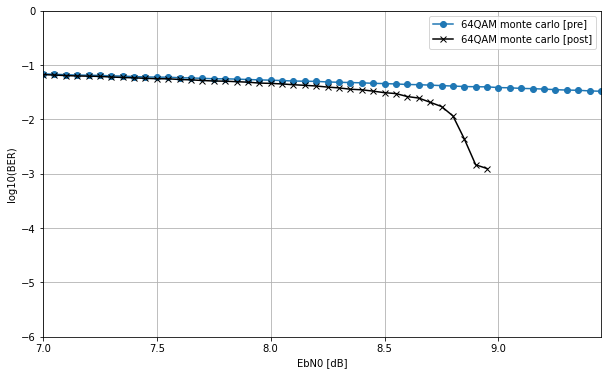

In [9]:
# Plot simulation results       
BERpre[BERpre==0] = np.nan
BERpost[BERpost==0] = np.nan

plt.figure(figsize=(10,6))
for ii, M in enumerate(qamOrder):
    plt.plot(
        EbN0dB_,
        np.log10(BERpre[:, ii]),
        'o-',
        label=f'{str(M)}QAM monte carlo [pre]',
    )


#plt.gca().set_prop_cycle(None)

for ii, M in enumerate(qamOrder):
    plt.plot(
        EbN0dB_,
        np.log10(BERpost[:, ii]),
        'kx-',
        label=f'{str(M)}QAM monte carlo [post]',
    )


plt.xlim(min(EbN0dB_), max(EbN0dB_))
plt.ylim(-6, 0)
plt.legend();
plt.xlabel('EbN0 [dB]');
plt.ylabel('log10(BER)');
plt.grid()